# CIFAR-10 Image Classification with CNN

This notebook demonstrates how to build, train, and evaluate a Convolutional Neural Network (CNN) on the CIFAR-10 dataset.

## Import Required Libraries

In [78]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

## Check GPU Availability

Let's check if a GPU is available for training to speed up the process significantly.

In [79]:
# Check if GPU is available and configure TensorFlow to use it optimally
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            
        # Restrict TensorFlow to only use the first GPU if multiple are available
        # Adjust if you want to use multiple GPUs
        # tf.config.set_visible_devices(gpus[0], 'GPU')
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
        print("GPU acceleration is enabled!")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found. Training will run on CPU, which will be significantly slower.")
    print("Consider using Google Colab or another platform with GPU access for faster training.")

Num GPUs Available:  0
No GPU found. Training will run on CPU, which will be significantly slower.
Consider using Google Colab or another platform with GPU access for faster training.


In [80]:
# Enable mixed precision training for further acceleration on compatible GPUs (like NVIDIA Volta, Turing, or Ampere)
# This can significantly speed up training with minimal impact on accuracy
if gpus:
    try:
        # Enable mixed precision training
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print("Mixed precision enabled. Using dtype:", policy.compute_dtype)
    except Exception as e:
        print("Could not enable mixed precision:", e)
        print("Continuing with default precision.")

## Load CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

In [81]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Define class names for the CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


## Visualize Dataset Samples

Let's visualize some random samples from the dataset to get a better understanding of the images.

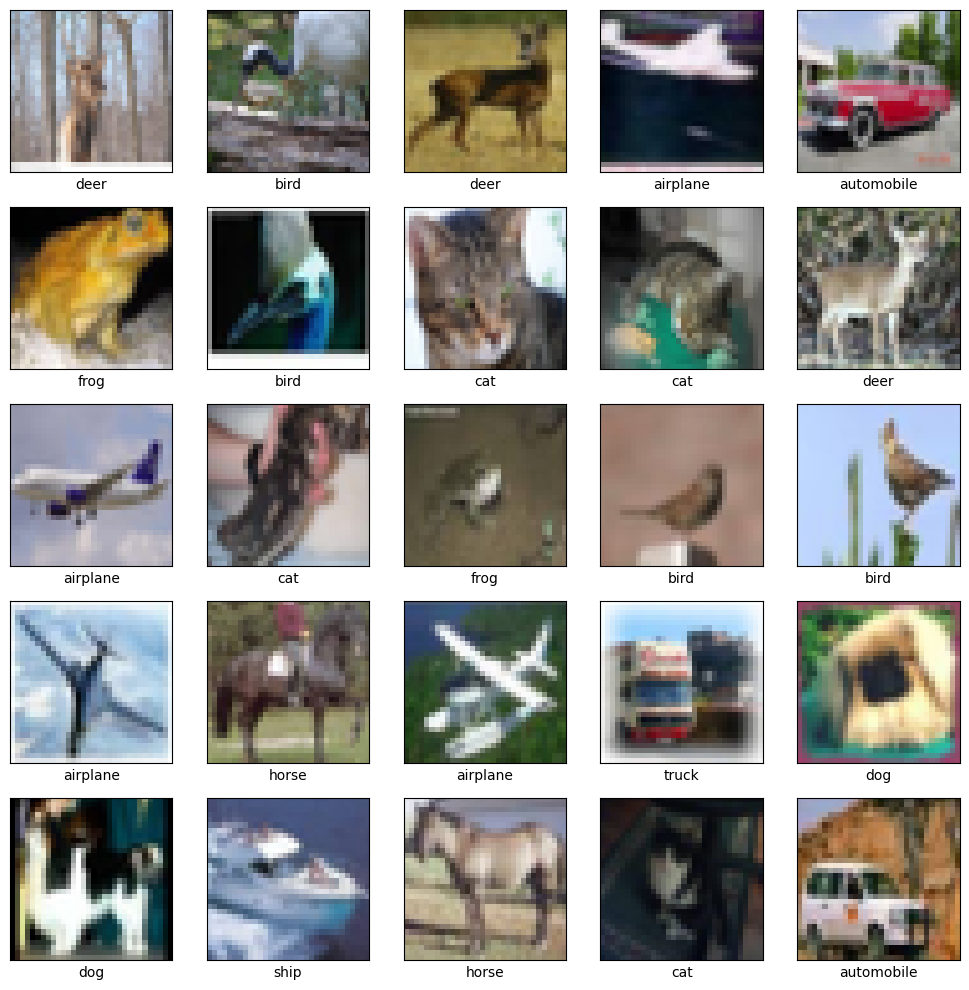

In [82]:
# Display random images from the training set
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(0, X_train.shape[0])
    plt.imshow(X_train[index])
    # The label is a single-element array, so we need to extract the value
    plt.xlabel(class_names[y_train[index][0]])
plt.tight_layout()
plt.show()

## Preprocess the Data

We need to preprocess the data before feeding it into our neural network:
1. Normalize the pixel values to be between 0 and 1
2. Convert the class labels to one-hot encoded vectors
3. Standardize the data (zero mean and unit variance)

In [83]:
# Normalize pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Standardize the data (zero mean and unit variance) after normalization
# This helps dense networks train better

# Calculate mean and std for each channel across the training set
train_mean = np.mean(X_train, axis=(0, 1, 2))
train_std = np.std(X_train, axis=(0, 1, 2))

# Apply standardization to all datasets
X_train = (X_train - train_mean) / (train_std + 1e-7)
X_test = (X_test - train_mean) / (train_std + 1e-7)

print("After standardization:")
print(f"Training data mean: {np.mean(X_train):.4f}, std: {np.std(X_train):.4f}")
print(f"Test data mean: {np.mean(X_test):.4f}, std: {np.std(X_test):.4f}")

# Convert class labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)

print("Shape of X_train after normalization:", X_train.shape)
print("Shape of y_train after one-hot encoding:", y_train_one_hot.shape)

After standardization:
Training data mean: -0.0000, std: 1.0000
Test data mean: 0.0128, std: 0.9987
Shape of X_train after normalization: (50000, 32, 32, 3)
Shape of y_train after one-hot encoding: (50000, 10)
Training data mean: -0.0000, std: 1.0000
Test data mean: 0.0128, std: 0.9987
Shape of X_train after normalization: (50000, 32, 32, 3)
Shape of y_train after one-hot encoding: (50000, 10)


## Data Normalization and Train-Test-Validation Split

We already normalized and standardized our data, but we need to create a validation set from our training data to monitor the model's performance during training and avoid overfitting.

In [84]:
# Create a validation set from the training data
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets (80% train, 20% validation)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train_one_hot, test_size=0.2, random_state=42)

print("Final training data shape:", X_train_final.shape)
print("Validation data shape:", X_val.shape)
print("Final training labels shape:", y_train_final.shape)
print("Validation labels shape:", y_val.shape)

# Verify normalization and standardization by checking the min and max values
print("\nTraining data min value:", X_train_final.min())
print("Training data max value:", X_train_final.max())
print("Validation data min value:", X_val.min())
print("Validation data max value:", X_val.max())
print("Test data min value:", X_test.min())
print("Test data max value:", X_test.max())

Final training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
Final training labels shape: (40000, 10)
Validation labels shape: (10000, 10)

Training data min value: -1.9892124
Training data max value: 2.126794
Validation data min value: -1.9892124
Validation data max value: 2.126794
Test data min value: -1.9892124
Test data max value: 2.126794


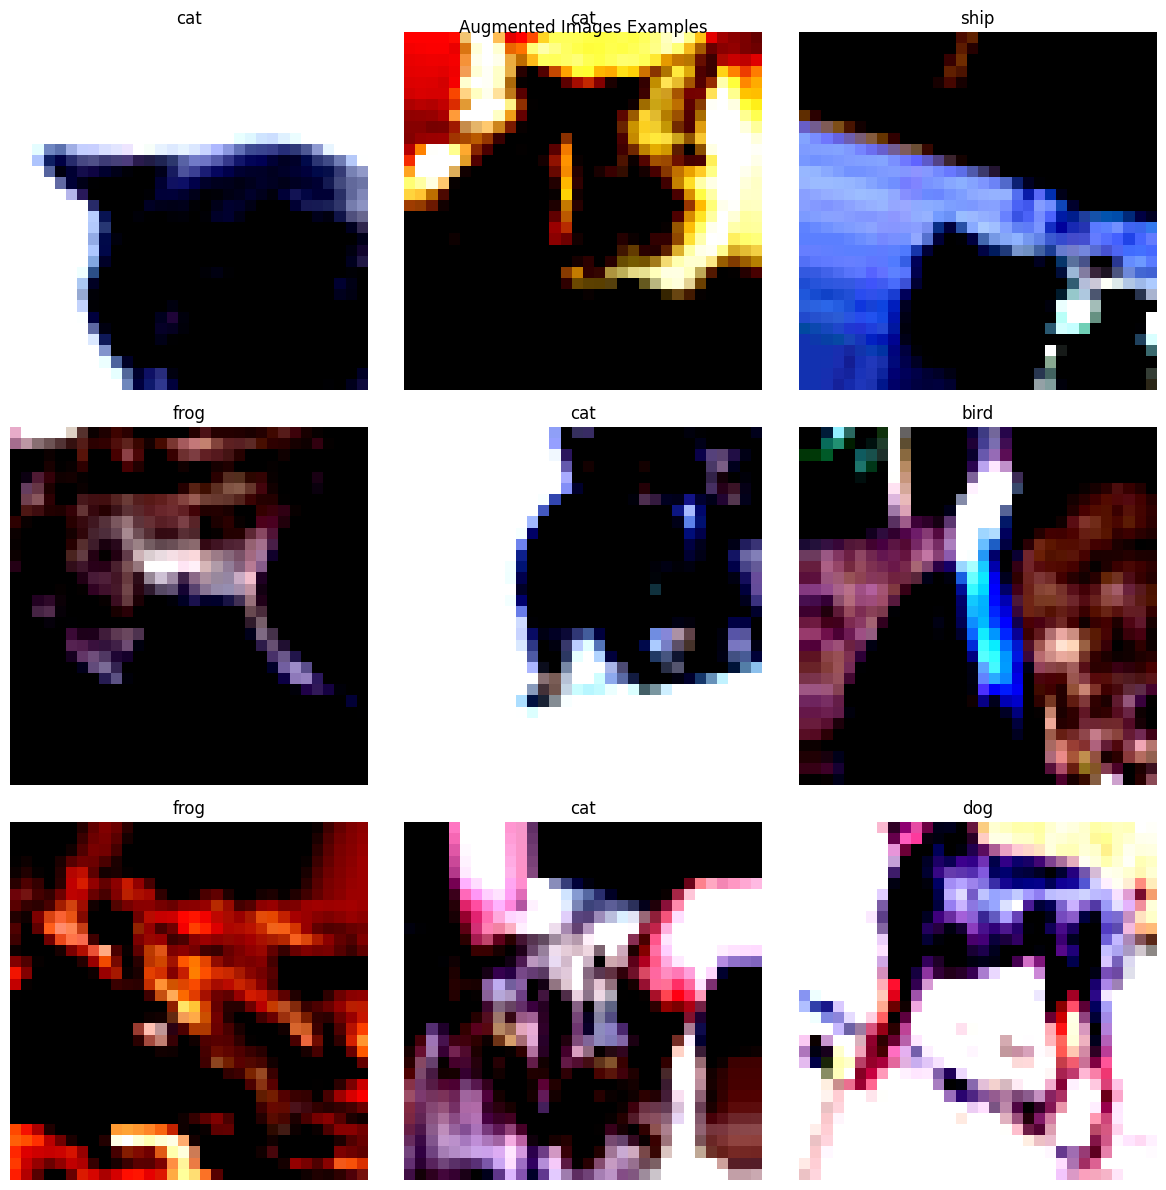

In [85]:
# Create data augmentation pipeline for training data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=20,  # Increased rotation range
    width_shift_range=0.2,  # More aggressive horizontal shifts
    height_shift_range=0.2,  # More aggressive vertical shifts
    horizontal_flip=True,
    zoom_range=0.2,  # More zoom variation
    shear_range=0.1,  # Add shear transformation
    fill_mode='nearest'  # Fill in newly created pixels
)

# Visualize some augmented images
plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(X_train_final[:9], y_train_final[:9], batch_size=9):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_batch[i])
        plt.title(class_names[np.argmax(y_batch[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Augmented Images Examples')
    plt.show()
    break  # otherwise the generator would loop indefinitely

## Analyze the Distribution of Categories

Let's analyze the distribution of categories in the CIFAR-10 training set.

Category Distribution in Training Set:
     Category  Count
0    airplane   5000
1  automobile   5000
2        bird   5000
3         cat   5000
4        deer   5000
5         dog   5000
6        frog   5000
7       horse   5000
8        ship   5000
9       truck   5000


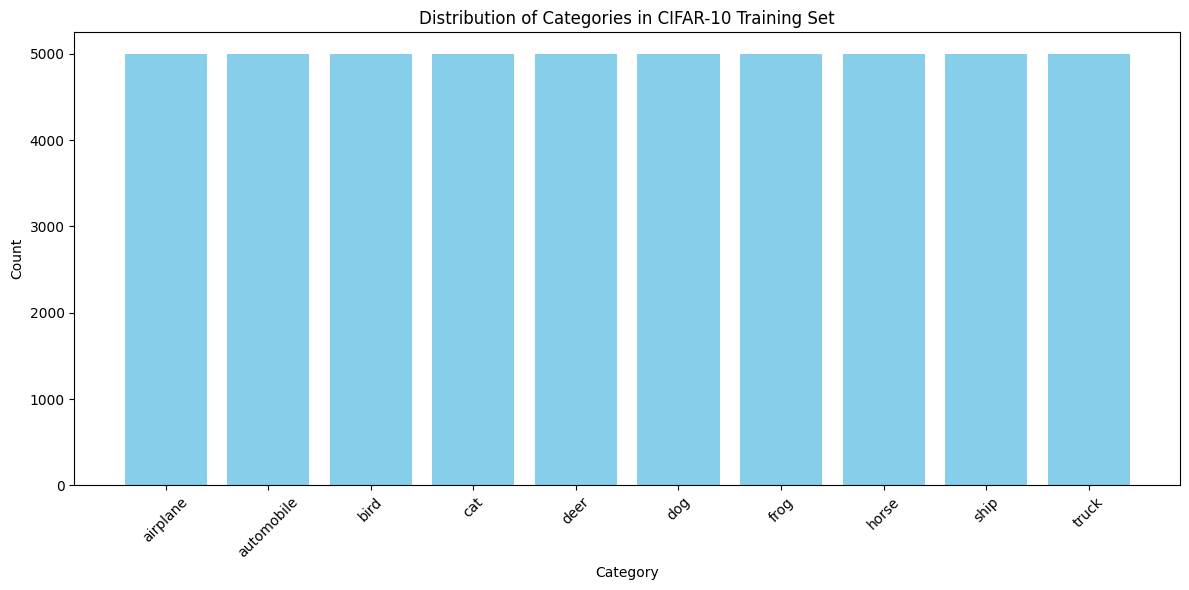

In [86]:
# Analyze the distribution of categories in the training set
import pandas as pd
from collections import Counter

# Count the occurrences of each class in the training set
unique_train, counts_train = np.unique(y_train, return_counts=True)
train_distribution = dict(zip([class_names[i[0]] for i in unique_train.reshape(-1, 1)], counts_train))

# Create a DataFrame to display the distribution
df_distribution = pd.DataFrame({
    'Category': list(train_distribution.keys()),
    'Count': list(train_distribution.values())
})

print("Category Distribution in Training Set:")
print(df_distribution)

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(df_distribution['Category'], df_distribution['Count'], color='skyblue')
plt.title('Distribution of Categories in CIFAR-10 Training Set')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Build a Convolutional Neural Network (CNN)

Now we'll build a Convolutional Neural Network using the Keras Sequential API.

## 3. Build Dense Neural Network

We'll build a Deep Neural Network using only Dense layers with the following architecture:
- Input shape: (32, 32, 3) flattened to 3072
- Multiple dense layers with decreasing neurons
- Output layer with 10 neurons (for the 10 classes)

In [87]:
# Build a larger, more effective Dense Neural Network for CIFAR-10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

def build_model(input_shape=(32, 32, 3), 
                hidden_layers=[2048, 1024, 512, 256, 128], 
                dropout_rates=[0.2, 0.3, 0.4, 0.4, 0.5], 
                weight_decay=1e-4,
                num_classes=10):
    """
    Build an improved dense neural network with large capacity and regularization.
    
    Parameters:
    - input_shape: Shape of input images, default (32, 32, 3)
    - hidden_layers: List of integers specifying the number of neurons in each hidden layer
    - dropout_rates: List of dropout rates to apply after each hidden layer
    - weight_decay: L2 regularization factor to apply to all Dense layers
    - num_classes: Number of output classes, default 10
    
    Returns:
    - Keras model
    """
    model = Sequential()
    
    # Flatten the input image to a 1D array
    model.add(Flatten(input_shape=input_shape))
    
    # Add hidden layers dynamically based on the hidden_layers list
    for i, layer_size in enumerate(hidden_layers):
        # Add Dense layer with specified number of neurons and L2 regularization
        model.add(Dense(layer_size, 
                        activation='relu', 
                        kernel_regularizer=l2(weight_decay),
                        kernel_initializer='he_uniform'))  # He initialization works well with ReLU
        model.add(BatchNormalization())
        
        # Add dropout with rate from dropout_rates if available
        dropout_rate = dropout_rates[i] if i < len(dropout_rates) else 0.5
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Create a deeper and wider model with better regularization
hidden_layers = [2048, 1024, 512, 256, 128]  # Larger network with more capacity
dropout_rates = [0.2, 0.3, 0.4, 0.4, 0.5]  # Progressive dropout
weight_decay = 1e-4  # L2 regularization

model = build_model(
    hidden_layers=hidden_layers,
    dropout_rates=dropout_rates,
    weight_decay=weight_decay
)

# Print the model summary
model.summary()

# Print the architecture details
print(f"\nModel Architecture:")
print(f"- Input shape: (32, 32, 3) flattened to 3072")
print(f"- Hidden layers: {hidden_layers}")
print(f"- Dropout rates: {dropout_rates}")
print(f"- Weight decay (L2): {weight_decay}")
print(f"- Output layer: 10 neurons (softmax)")

c:\personal\Holberton\holbertonschool-machine_learning\.venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2048)           │     6,293,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,097,866 (34.71 MB)

 Trainable params: 9,089,930 (34.68 MB)

 Non-trainable params: 7,936 (31.00 KB)


Model Architecture:
- Input shape: (32, 32, 3) flattened to 3072
- Hidden layers: [2048, 1024, 512, 256, 128]
- Dropout rates: [0.2, 0.3, 0.4, 0.4, 0.5]
- Weight decay (L2): 0.0001
- Output layer: 10 neurons (softmax)


## 4. Compile Model

Now we'll compile the model with:
- An optimizer (Adam)
- Loss function (categorical_crossentropy for multi-class classification)
- Metrics (accuracy to monitor)

In [88]:
# Compile the model with an advanced optimization strategy
from tensorflow.keras.optimizers import Adam

# Use Adam optimizer with a carefully tuned learning rate instead of SGD
# Adam often works better for dense networks with proper regularization
initial_learning_rate = 0.001  # Start with a moderate learning rate

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

print("Model compiled with:")
print(f"- Optimizer: Adam")
print(f"- Initial learning rate: {initial_learning_rate}")
print("- Loss function: categorical_crossentropy")
print("- Metrics: accuracy")

Model compiled with:
- Optimizer: Adam
- Initial learning rate: 0.001
- Loss function: categorical_crossentropy
- Metrics: accuracy


## 5. Train Model

We'll train the model using:
- Our training and validation data
- Data augmentation
- Early stopping to prevent overfitting
- Model checkpointing to save the best model

In [ ]:
# Set up callbacks for early stopping and model checkpointing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import os
import datetime

# Create a directory for model checkpoints if it doesn't exist
checkpoint_dir = './model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Create improved callbacks
callbacks = [
    # Early stopping to prevent overfitting - increased patience for better convergence
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,  # Increased patience to give model more time to improve
        restore_best_weights=True,
        verbose=1
    ),
    # Model checkpointing to save the best model
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'cifar10_best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    # More aggressive learning rate reduction
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,  # Reduce learning rate by half instead of 90%
        patience=3,  # Be more responsive to plateaus
        min_lr=1e-6,  # Allow learning rate to go very small
        verbose=1
    ),
    # TensorBoard for visualization
    TensorBoard(
        log_dir='./logs/cifar10_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
        histogram_freq=1
    )
]

# Set larger batch size for better utilization of GPU memory
batch_size = 128  # Doubled batch size
epochs = 150  # Allow for more training epochs

# Create enhanced data augmentation with more transformations
datagen = ImageDataGenerator(
    rotation_range=20,  # Increased rotation range
    width_shift_range=0.2,  # More aggressive horizontal shifts
    height_shift_range=0.2,  # More aggressive vertical shifts
    horizontal_flip=True,
    zoom_range=0.2,  # More zoom variation
    shear_range=0.1,  # Add shear transformation
    fill_mode='nearest'  # Fill in newly created pixels
)

# Train the model with data augmentation
datagen.fit(X_train_final)

# Start training with enhanced parameters
print("Starting model training with enhanced configuration...")
history = model.fit(
    datagen.flow(X_train_final, y_train_final, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

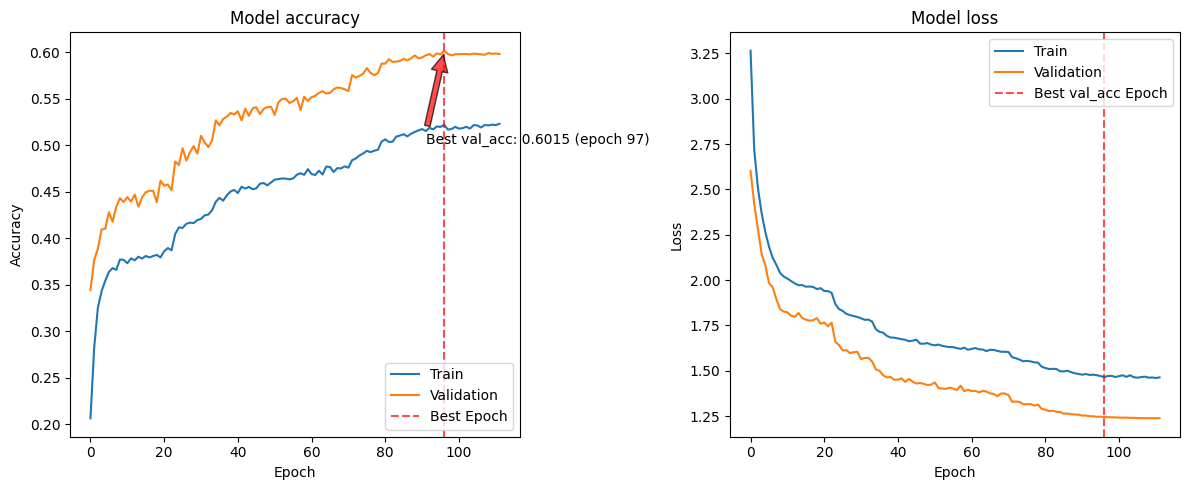

Best validation accuracy: 0.6015 at epoch 97


In [102]:
# Plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    
    # Find the epoch with the best validation accuracy
    best_acc_epoch = np.argmax(history.history['val_accuracy'])
    best_acc = history.history['val_accuracy'][best_acc_epoch]
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.axvline(x=best_acc_epoch, color='r', linestyle='--', alpha=0.7)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.annotate(f'Best val_acc: {best_acc:.4f} (epoch {best_acc_epoch+1})',
                 xy=(best_acc_epoch, best_acc),
                 xytext=(best_acc_epoch - 5, best_acc - 0.1),
                 arrowprops=dict(facecolor='red', shrink=0.05, alpha=0.7))
    plt.legend(['Train', 'Validation', 'Best Epoch'], loc='lower right')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    # Only showing the best val_accuracy epoch line in both plots for reference
    plt.axvline(x=best_acc_epoch, color='r', linestyle='--', alpha=0.7)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Best val_acc Epoch'], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional information about best epoch
    print(f"Best validation accuracy: {best_acc:.4f} at epoch {best_acc_epoch+1}")

# Plot the training history
plot_training_history(history)

## 6. Evaluate / Test Model

Now we'll evaluate the model on the test dataset to see how well it generalizes to unseen data.

In [103]:
# Evaluate the model on the test dataset
print("Evaluating model on test dataset...")
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating model on test dataset...
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6006 - loss: 1.2503
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6006 - loss: 1.2503
Test Loss: 1.2502
Test Accuracy: 0.5984
Test Loss: 1.2502
Test Accuracy: 0.5984


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


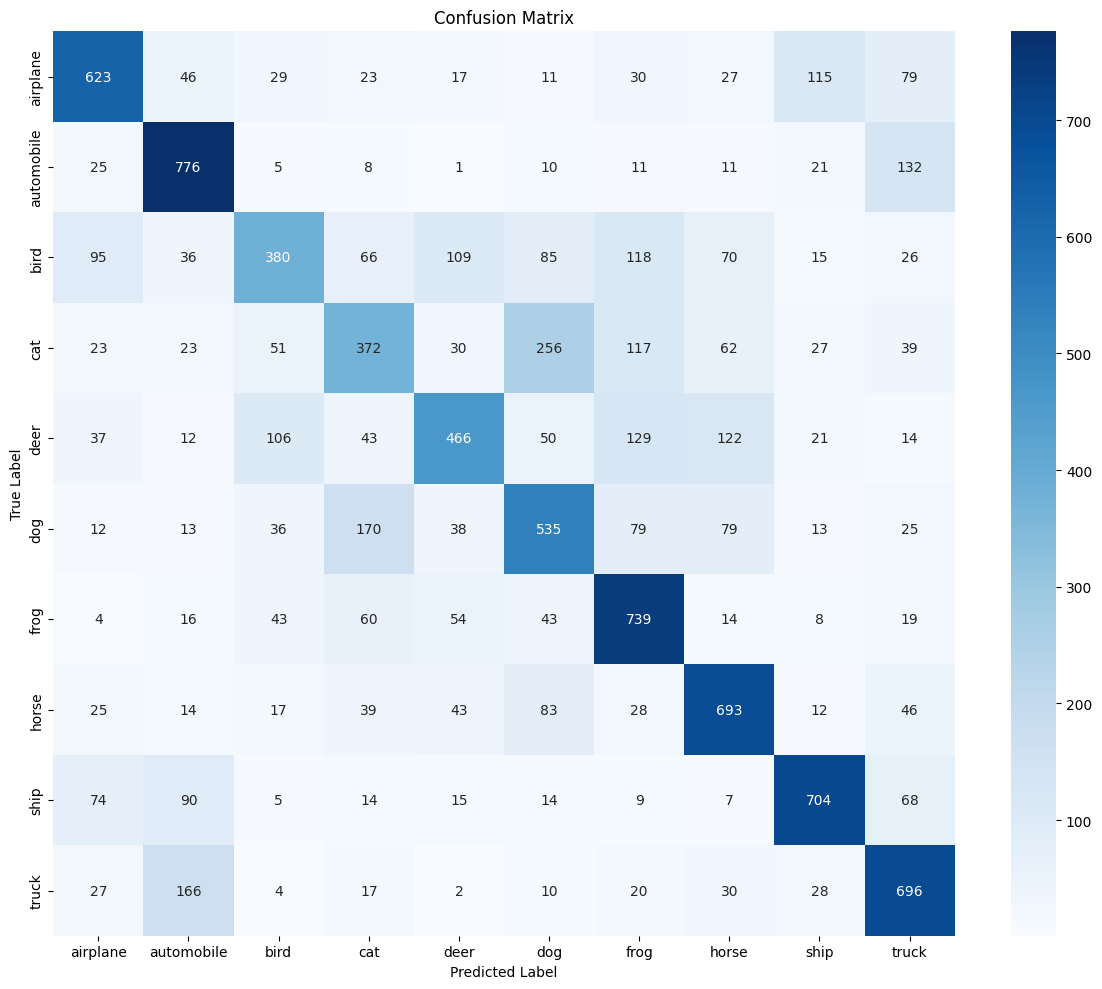

Classification Report:
              precision    recall  f1-score   support

    airplane       0.66      0.62      0.64      1000
  automobile       0.65      0.78      0.71      1000
        bird       0.56      0.38      0.45      1000
         cat       0.46      0.37      0.41      1000
        deer       0.60      0.47      0.53      1000
         dog       0.49      0.54      0.51      1000
        frog       0.58      0.74      0.65      1000
       horse       0.62      0.69      0.66      1000
        ship       0.73      0.70      0.72      1000
       truck       0.61      0.70      0.65      1000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.59     10000
weighted avg       0.60      0.60      0.59     10000



In [104]:
# Generate predictions on the test set and create a confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

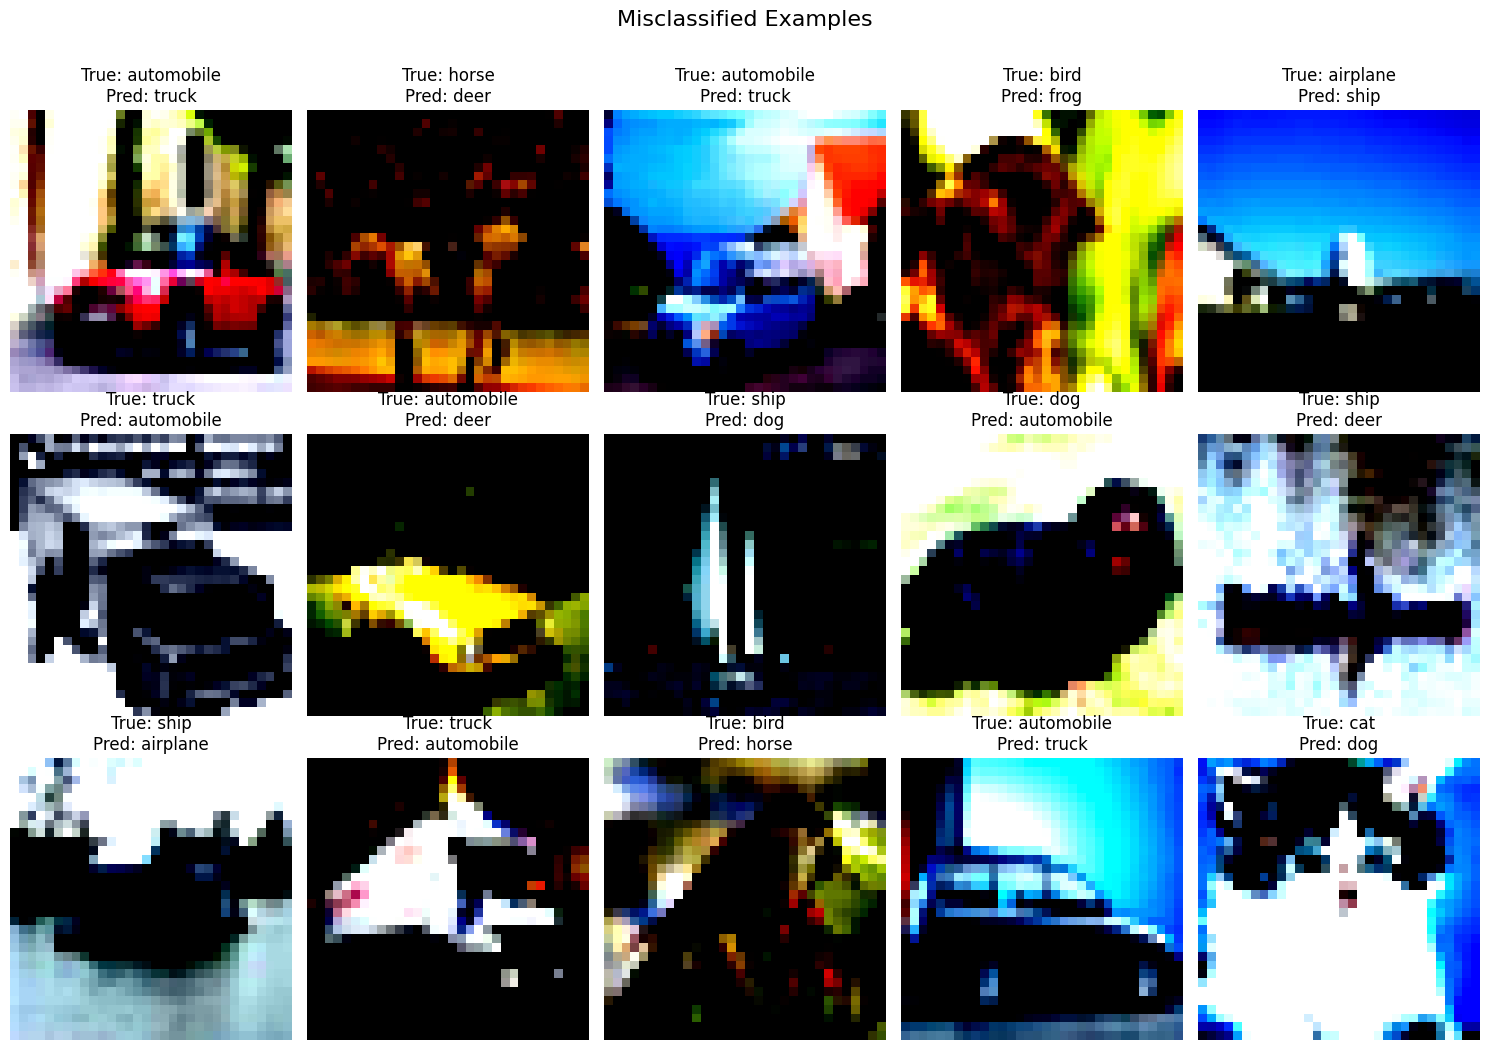

In [105]:
# Display some misclassified examples
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Select a random subset of misclassified images to display
num_display = min(15, len(misclassified_indices))
selected_indices = np.random.choice(misclassified_indices, num_display, replace=False)

# Plot the misclassified images
plt.figure(figsize=(15, 10))
for i, idx in enumerate(selected_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred_classes[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Misclassified Examples', y=1.05, fontsize=16)
plt.show()

## Save the Trained Model

Finally, we'll save the trained model so we can use it later without having to retrain.

In [99]:
# Save the entire model to a HDF5 file
model.save('cifar10_model.h5')
print("Model saved as 'cifar10_model.h5'")

Model saved as 'cifar10_model.h5'


## Test Custom Images

Let's create a directory for test images and set up a function to test the saved model on any custom images uploaded to that directory.

In [109]:
import os
import glob
from PIL import Image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Create a directory for test photos if it doesn't exist
test_photos_dir = './Test_Photos'
os.makedirs(test_photos_dir, exist_ok=True)
print(f"Created directory for test photos: {test_photos_dir}")
print("You can now upload images to this directory to test the model.")

Created directory for test photos: ./Test_Photos
You can now upload images to this directory to test the model.


Checking for images in the Test_Photos directory...


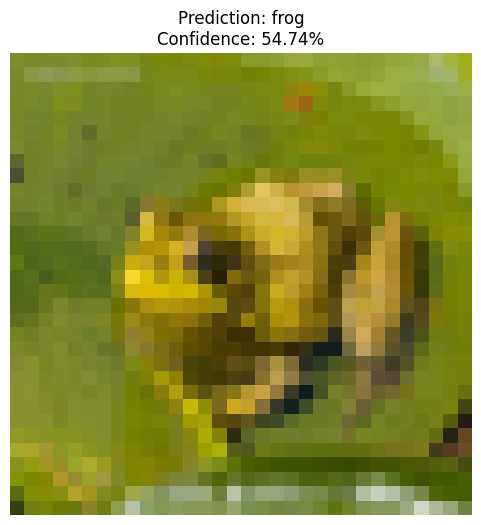

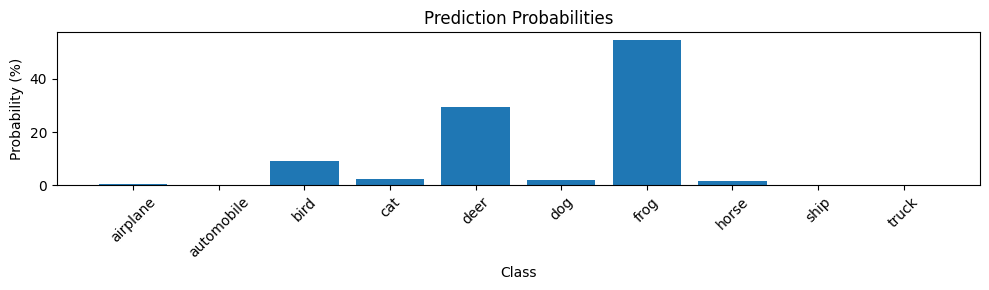

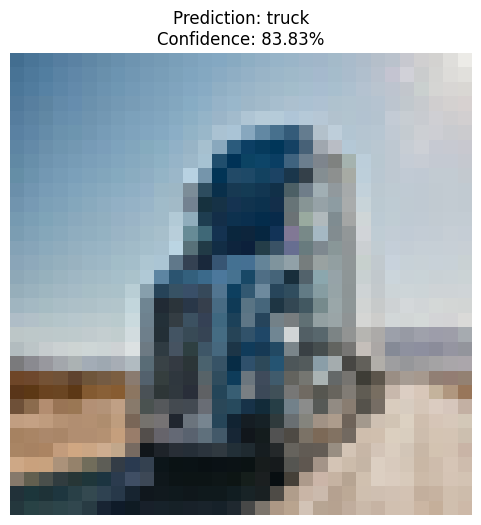

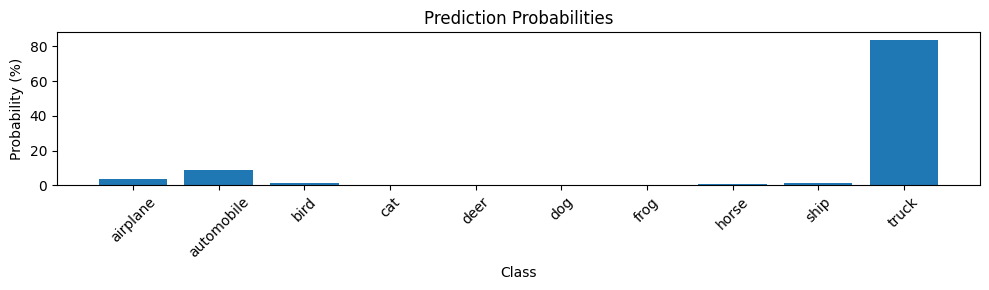

In [114]:
def preprocess_image(image_path):
    """Preprocess an image to match the format expected by the model"""
    # Load the image
    img = Image.open(image_path)
    
    # Resize to 32x32 (CIFAR-10 image size)
    img = img.resize((32, 32), Image.LANCZOS)
    
    # Convert to numpy array
    img_array = np.array(img)
    
    # Make sure it has 3 channels (RGB)
    if len(img_array.shape) == 2:  # Grayscale
        img_array = np.stack([img_array, img_array, img_array], axis=-1)
    elif img_array.shape[2] == 4:  # RGBA
        img_array = img_array[:, :, :3]
    
    # Normalize to 0-1
    img_array = img_array.astype('float32') / 255.0
    
    # Apply the same standardization that was used in training
    img_array = (img_array - train_mean) / (train_std + 1e-7)
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array, img

def test_custom_images(model_path, image_dir):
    """Test the model on all images in the specified directory"""
    # Load the saved model
    model = load_model(model_path)
    
    # Get all image files in the directory
    image_files = glob.glob(os.path.join(image_dir, '*.*'))
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    image_files = [f for f in image_files if os.path.splitext(f.lower())[1] in image_extensions]
    
    if not image_files:
        print(f"No image files found in {image_dir}. Please upload some images.")
        return
    
    # Process each image
    for img_path in image_files:
        try:
            # Preprocess the image
            img_array, original_img = preprocess_image(img_path)
            
            # Make prediction
            predictions = model.predict(img_array, verbose=0)[0]
            predicted_class = np.argmax(predictions)
            confidence = predictions[predicted_class] * 100
            
            # Display the image and prediction
            plt.figure(figsize=(6, 6))
            plt.imshow(original_img)
            plt.title(f"Prediction: {class_names[predicted_class]}\nConfidence: {confidence:.2f}%")
            plt.axis('off')
            plt.show()
            
            # Display the prediction distribution
            plt.figure(figsize=(10, 3))
            plt.bar(class_names, predictions * 100)
            plt.title('Prediction Probabilities')
            plt.xlabel('Class')
            plt.ylabel('Probability (%)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing {os.path.basename(img_path)}: {e}")

# Test the model on any images in the Test_Photos directory
print("Checking for images in the Test_Photos directory...")
test_custom_images('cifar10_model.h5', test_photos_dir)

## Instructions for Uploading Test Images

To test the model on your own images:

1. Upload images to the `Test_Photos` directory using your file explorer or the VS Code explorer panel
2. Run the cell above to process and classify all images
3. The model will resize your images to 32x32 pixels (CIFAR-10 format) and make predictions

You can run the cell multiple times as you add more images to the directory.

Note: The model was trained on tiny 32x32 images from specific categories (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), so performance on arbitrary images may vary.

In [113]:
def test_new_images():
    """Run this function after adding new images to the Test_Photos directory"""
    print("Testing images in the Test_Photos directory...")
    test_custom_images('cifar10_model.h5', test_photos_dir)

# Uncomment and run the line below after adding new images
# test_new_images()